# What are the common activities that the victims were engaged in prior to the accident?

In [35]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import xlsxwriter

# List Of Category indexes as per stated in the CA document

In [36]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

# Classes to store the category and case items together with helper functions

In [37]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, str(len(self.ActivityTokensVerb)) , str(len(self.ActivityTokensChunk))))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

# Read from and write to excel, populate case items, intialization of categories

In [38]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    global OshaCasesDF
    global MsiaCasesDF
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaCasesDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column,
    for index,row in OshaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title'], row['Summary'], row['Cause'], GetCategoryIndex(row['Cause']))
        OshaCaseItems.append(TempCaseItem)

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    global OshaCategories
    MsiaCategories = []
    OshaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)
        OshaCategories.append(tempcat)
        
def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it
    
def WriteToExcel(filename, SelectedCaseItemsDF):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    # Convert the dataframe to an XlsxWriter Excel object.
    SelectedCaseItemsDF.to_excel(writer, sheet_name='Sheet1')
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()    

# Visualisation function to plot frequency distribution, word cloud and list some of the common activities

In [39]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def Visualisation(category):   
    #tokens = word_tokenize(text)
    if (len(category.ActivityTokensVerb)>0):
        # frequecy distribution chart
        print(category.Name)
        #tokens_clean = [ t for t in category.ActivityTokensVerb if len(t) >= 3 ]
        tokens_clean_single = []
        for tok1 in category.ActivityTokensVerb:
            for tok2 in tok1:
                tokens_clean_single.append(tok2)
        fd = nltk.FreqDist(tokens_clean_single)
        fd.most_common(25)
        TopActivityTokens = fd.most_common(3)
        fd.plot(25)
        #print(tokens_clean_single)
        #print(TopActivityTokens)
        
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
        text = ' '.join(tokens_clean_single)
        wc = WordCloud(background_color="white").generate(text)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()    
        
        chunks_limit = 10
        print("Top 3 activity word and their sentences")
        print("=======================================\n")
        for word in TopActivityTokens:
            chunks_count = 0
            underline = ""
            print('\n' + word[0])
            for c in word[0]:
                underline += '='
            print(underline + '\n')
            #Populate sentences belonging to top tokens
            for chunk1 in category.ActivityTokensChunk:
                for chunk2 in chunk1:
                    chunk_token = nltk.sent_tokenize(chunk2)
                    chunk_lemma_token = get_lemma(chunk_token)
                    #print(chunk_lemma_token)
                    #chunk_text = ' '.join(chunk)
                    if len(chunk_lemma_token) >= 1:
                        #print (chunk_lemma_token)
                        for token in chunk_lemma_token:
                            if word[0] in get_lemma_word(token.split(' ')[0]):
                                if (chunks_count < 10):
                                    print(chunk2)
                                chunks_count += 1

            print("\n")
    else:
        print("Visualisation Function : NO DATA AVAILABLE")



# Text Mining helper functions 
- get_lemma - lemmatizer to get the base word based on speech tag
- get_stem - similar to get_lemma but some of the base words are not correct, so I did not use this
- get_verb_count - returns number of verb word found in the sentence
- filter_off_unwanted chunks - custom filter to more accurately extract verb associated with the activities

In [40]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_lemma_word(text):
    return WNlemma.lemmatize(text, 'v')

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have']
    filter_all_words = ['kill', 'carry out work']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in str(' '.join(get_lemma(untag(subtree)))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in str(' '.join(get_lemma(untag(subtree)))) ):
            return False, subtree
    if get_verb_count(untag(subtree)) > 0:  
        return True, subtree
    else: 
        return False, subtree

def clean_up_chunk(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    text = text.replace(' ','')
    return text

# Main function to extract the activities sentences and verb
- 1st loop (ie. OCC1) is used for extracting the sentences containing the activities. The RegexpParser will look for verb in past tenses(VBD), base form(VB), past participle(VBN), present participle(VBG) etc that is constructed together with nouns(singular, plural, proper noun,) as well as preposition(IN), adjective(JJ), particle(PR).

- 2nd loop (ie. OCC2) is used to further extract the base verb that is found using OCC1.

In [41]:
def extract_activities_chunk_and_verb(text):
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """
    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = []
    ExtractedActivitiesVerb = []
    if (not text=="") and (len(text) >= 3):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_chunk(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_chunk(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk.append(token_chunk_clean_str)
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb.append(clean_up_verb(str(tokens_verb_lem_clean)))
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

# Main Loop
- Initializes the case and categories item
- create the lemmatizer and stemmer objects
- read from excel and populate the case and categories

In [42]:
# Initialize     
MsiaCategories = []
MsiaCaseItems = []
MsiaCasesDF = []
OshaCategories = []
OshaCaseItems = []
OshaCasesDF = []

MsiaCasesFile = 'MsiaAccidentCases.xlsx'
#the Osha case file must have the causes populated by the predictor model developed by Vincent
OshaCasesFile = 'osha1.xlsx'

#NLTK Objects
# lemmatize to convert to base words depending on speech tagging
WNlemma = nltk.WordNetLemmatizer()
# stemmer to get the base words
Stemmer = nltk.SnowballStemmer('english')   

#Initilize categories
InitializeCategories()
#Read data from excel and populate case items
ReadFromExcelAndPopulateCase()

# Flags to determine which data set to use. 
- ProcessMsiaDataSet for Msia Dataset
- ProcessOshaDataSet for Osha Dataset

In [43]:
# if False, means process the Osha dataset
ProcessMsiaDataSet = False
ProcessOshaDataSet = True

# Main Processing Section 1
- Loops through each case item then populate the activities sentences and verb token 

In [44]:
if ProcessMsiaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in MsiaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in MsiaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

In [45]:
if ProcessOshaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in OshaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in OshaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

installing ladder scaffold structure(1)
clothing point(1)
paving equipment operator(1)
earthmoving equip bulldozer maintenance(1)
installing arm fracture face abrasion(1)
handling ind trk operator(1)
loading ramp loading dock(2)
walking surface fall contusion abrasion(1)
grinding machine(1)
grinding machine(1)
sandblasting abrasive blasting(2)
rotating parts hand(1)
sandblasting abrasive blasting(2)
sandblasting face neck concussion(1)
sandblasting respirator(1)
grinding wheel(1)
sharpening machine glove thumb laceration rotating parts(2)
cleaning chemical burn ppe jet fuel hand(1)
hoisting mechanism(1)
loading machinist abrasive wheel(1)
handling rotating parts(2)
rotating parts work rules(1)
cleaning refinery(1)
packing hand conveyor belt roller(1)
cleaning conveyor(1)
clothing forearm(1)
rotating shaft(1)
clothing fracture rib work rules(1)
flying object abrasive wheel laceration fracture leg(1)
flying object fracture grinder(1)
flying object eye ppe(1)
rotating parts(1)
grinding ma

welding welding welder(2)
welding cable welding installing(3)
burning naphtha fire(1)
welding arc welding truck construction(2)
welding head(1)
welding vapor support posts(1)
welding repair slip(1)
welding ppe(1)
clothing oxygen fire(1)
welding argon(1)
welding pipe(1)
painting oxygen deficiency inhalation inattention(1)
welding ventilation argon(1)
installing electric motor arm metal wire ppe(1)
plumbing extension ladder roof fall protection fall fracture arm(1)
rotating parts arm laceration(1)
climbing on column fall(1)
cleaning printing machine(2)
molding machine caught(1)
loading tractor trailer pallet loading dock run(2)
felling unstable position(1)
scaffolding asbestos asbestos removal demolition(1)
decking installing fracture shoulder(2)
flying object concussion head(1)
opening work rules(1)
opening fall protection fall demolition construction asbestos removal work rules(1)
installing asbestos(1)
scaffolding elevator asbestos(1)
riding on equipment(1)
flying object building(2)
c

cleaning fan fan(1)
lubricating fluid fracture face blood clot brain hemorrhage eye(1)
servicing fire burn oil rig blowout(1)
servicing blowout(1)
installing pipe(1)
flying object abrasion contusion(1)
servicing explosion(1)
drilling explosion explosion(1)
flying object pipeline blowout(1)
servicing blowout(1)
installing head contusion gas(1)
flying object explosion(1)
flying object work rules(1)
drilling derrickman equipment failure(1)
servicing fire explosion(1)
drilling explosion oil rig(1)
drilling work rules(1)
ring blowout(1)
flying object fracture arm(1)
inflating flying object mechanic(2)
inflating head tire rim neck(1)
inflating blowout(1)
piping blowout(1)
inflating blowout(1)
flying object high pressure blowout(1)
inflating restraining device work rules(2)
flying object point(1)
building board slip slippery surface fall fracture arm(1)
longshoring fall fracture boat work surface abdomen(1)
painting boat manhole compressor spark respirator cord set(1)
walking backward inatten

cementing hip struck(1)
loading seat belt(1)
felling bulldozer(1)
backing up unstable surface earthmoving equip(2)
earthmoving equip bulldozer dozer(1)
logging chain(1)
hoisting mechanism(1)
hoisting mechanism(1)
hoisting mechanism(1)
flying object bus(1)
jumping equipment failure wire rope platform(1)
jumping equipment failure fall(1)
installing retaining wall collapse(2)
refueling hand face burn(1)
pouring burn chemical burn leg ppe hose(1)
lighting poor visibility(1)
descending mechanic vehicle bus maintenance abrasion contusion(1)
burning bolt scrap yard(1)
testing electric shock(1)
installing electrician electrical work busbar elec(1)
lighting circuit busbar(1)
installing electrical elec(1)
installing electrical cabinet busbar(1)
rotating parts(1)
flying object bush hog(1)
flying object cylinder butane(1)
purging truck driver head(1)
installing sewage wall(1)
trimming back buttocks(1)
scaffolding head(1)
cleaning burn chemical(1)
handling slippery surface(1)
backing up agriculture

rigging choker setter(1)
logging fracture foot choker setter choker cable choker(1)
logging winch roller(1)
logging choker cable log(1)
yarding equipment failure pelvis work rules(1)
flying object unconsciousness neck choker cable choker setter(1)
rigging crane choker choker cable(1)
logging rigging choker setter(2)
logging choker setter(1)
logging choker setter(1)
logging mech malfunction(1)
riding on equipment(1)
disconnecting means(1)
installing electrical panel panelboard circuit breaker fire burn hand(1)
installing electric switch circuit breaker explosion burn hand leg(1)
installing circuit breaker(1)
clothing face chest(1)
installing circuit breaker ppe(1)
handling heart(1)
cleaning boiler(1)
flying object work rules(1)
loading heart(1)
cleaning drain pipe(1)
disconnecting means(1)
cleaning concrete(1)
cleaning clogged drain(1)
rotating parts foot control(1)
cleaning degreaser pressure release(1)
cleaning high temperature heat exhaustion heat(1)
cleaning fluid cleaning(2)
cleani

lubricating fluid(1)
installing metal sheet corrosion fall fall protection equipment failure(1)
servicing maintenance(1)
handling abdomen(1)
cleaning ppe safety shoe(1)
cleaning janitor(1)
scaffolding cotter pin(1)
rotating shaft rotating parts(2)
installing cotter pin work rules(1)
flying object chipper cotter pin(1)
flying object cotter pin cover torso(1)
hoisting mechanism cotter pin oil rig brake(1)
rigging fall(1)
welding cotton chest(1)
cleaning fall fall protection work rules(1)
cleaning maintenance machine operator(1)
backing up industrial truck unconsciousness(1)
handling caught(1)
cleaning press rotating parts(2)
cleaning lockout(1)
rotating knife struck(1)
cleaning arm cotton cotton gin(1)
cleaning agriculture electrical box fire(1)
servicing cotton picker pump hydrogen sulfide machine(1)
installing respiratory respiratory tract ventilation overexposure cough lung(1)
poisoning chlorine gas cylinder throat cough vomit eye(1)
decking hoist counterbalance roof(1)
hoisting mecha

rigging derrick derrickman derrick platform fall platform(1)
drilling work rules safety belt(1)
drilling derrick(1)
drilling fall(1)
servicing fall derrick construction derrick platform oil rig ladder fall protection(1)
drilling fall tie-off fall protection work rules(1)
drilling fall fall protection work rules(1)
drilling rope derrick platform fracture(1)
handling bracing caught(2)
rigging steel(1)
streetlighting overhead power line(1)
servicing collapse fracture(1)
rigging hoisting mechanism pipe(2)
servicing derrick oil rig(1)
drilling fall protection(1)
descending heat heat exhaustion(1)
descending fall head concussion(1)
descending stair(1)
descending fall fall protection concussion(1)
descending ppe fall fall protection fracture head spine rib(1)
descending ladder piling fall skull fracture(2)
descending fall fall protection(1)
descending guardrail warehouse(1)
poisoning throat chemical burn(1)
cleaning fluid caustic detergent(1)
cleaning heat face arm burn work rules(1)
cleaning

rotating shaft shaft(1)
rotating shaft gear(1)
rotating parts drive shaft(1)
lubricating fluid clothing(2)
rotating shaft(1)
loading laceration head(1)
loading truck(1)
flying object drop hammer abdomen(1)
flying object face(1)
flying object fracture arm drop hammer die equipment failure(1)
cleaning scuba drown(1)
backing up slope(1)
painting paint toluene xylene(1)
decking fall drug overdose(1)
piping inadequate maint(1)
handling mixer concrete shovel(1)
rotating parts drum(1)
welding drum industrial truck(1)
hoisting mechanism hoistline wire rope drum drum hoist load line(1)
hoisting mechanism work rules(1)
dismantling work rules(1)
ironing machine two-hand control(1)
clothing washing machine(2)
rotating parts concussion(1)
washing machine(1)
ironing machine(1)
cleaning clothing press iron(2)
cleaning hand control(1)
ironing machine two-hand control work rules(1)
cleaning foot(1)
drying furnace machine operator cleaning(2)
drying furnace hexane toluene(1)
drying furnace(1)
backing up

testing electrical fault burn(1)
testing electrical fault(1)
testing electric shock(1)
opening burn(1)
installing lighting lighting fixture ladder(3)
casting machine(1)
installing fall roof fall protection fracture(1)
installing electronic equipment(1)
testing lab(1)
hearing loss contusion laceration head(1)
lighting fixture stepladder concrete(1)
scaffolding stepladder(1)
installing industrial truck machine operator equipment failure fall vertebra face laceration(1)
walking surface(1)
bracing falling object unsecured door(2)
cleaning elevator gate lockout(1)
installing wall walk platform(1)
installing fall elevator shaft fall protection(1)
spraying rig agriculture(1)
rotating parts(1)
trimming tree fall protection lanyard(1)
longshoring dock(1)
rotating parts(1)
ironing machine(1)
cleaning burn hand finger(1)
trimming portable power tool(1)
poisoning headache nausea dizziness(1)
poisoning enclosed space toxic fumes(1)
handling end plate pipe(1)
handling crushed pallet(1)
handling work

forming machine(1)
forming machine heat(1)
forming machine laceration arm(1)
forming machine hand(1)
molding machine forming machine hand finger(2)
packing house food packaging mach mech malfunction(2)
forming machine(1)
forming machine caught(1)
forming machine concrete cleaning hand fracture(2)
forming machine toxic fumes(1)
forming machine(1)
forming machine plastic mfg maintenance cleaning roller(2)
forming machine hand finger(1)
logging yarding tree(2)
casting foundry heat(1)
handling fire burn(1)
pouring molten metal ladle spill(1)
felling frac tank(1)
servicing frac(1)
flying object(1)
servicing explosion fire burn oil tank frac tank vapor gas(1)
flying object frac tank(1)
servicing leg pressure vessel(1)
servicing flammable vapors flammable liquid smoking burn work rules(2)
handling housekeeping frac tank leg inattention(2)
servicing cleaning frac tank hydrogen sulfide toxic fumes(2)
cleaning work rules(1)
installing burn hand chemical chemical burn(1)
poisoning ventilation wor

handling handrail(1)
cleaning stair(1)
walking surface handrail(1)
scaffolding fall fall protection handrail(1)
scaffolding head fracture(1)
clothing caught(1)
felling hard hat concussion head(1)
rotating knife foot laceration fracture(1)
installing cover(1)
rotating parts(1)
installing roof ladder hatch(1)
opening hatch fall fracture leg carpenter(1)
warning sign work rules construction(1)
longshoring barge ship hatch winch equipment operator head concussion(1)
logging log haulback line(1)
logging work rules(1)
yarding mech mat handling(2)
flying object(1)
logging fracture(1)
logging rigging communication(2)
yarding haulback line choker(1)
logging haulback line loss(1)
logging haulback line work rules(1)
cleaning hazardous waste chemical(1)
handling ppe(1)
loading mech mat handling(2)
opening hip leg head(1)
binding machin struck(1)
hoisting mechanism rigging head mech malfunction(2)
hoisting mechanism transmission tower headache ball(1)
flying object(1)
10655184910/25/19951796King La

ironing machine guard caught(1)
installing pipe pipeline knee infection(1)
rotating parts(1)
handling work surface metal pipe(1)
installing heat exhaustion heat(1)
poisoning overexposure(1)
cleaning ventilation ppe(1)
cleaning washing machine(2)
burning work rules(1)
welding explosion isopropyl alcohol drum work rules(1)
flying object flammable vapors(1)
cleaning acetylene torch(1)
printing press isopropyl alcohol fire explosion(1)
welding acetylene explosion(1)
shoring jackhammer trench(1)
cleaning industrial truck(1)
cleaning unconsciousness slip(1)
cleaning janitor work rules(1)
cleaning jet fuel venting(2)
loading fall boom pin concussion head flying object(2)
dismantling crane jib crane boom pin(1)
rigging fracture(1)
logging puncture eye head(1)
installing joist(1)
planing machine joist walking surface(2)
walking on plank fall fracture rib pelvis(1)
decking crane(1)
moving equip slip fall(1)
moving equip(1)
moving equip jump start(1)
moving equip(1)
moving equip(1)
moving equip(1

trimming loading log truck(2)
logging log truck driver(1)
felling logger tree(1)
logging logger(1)
logging logger(1)
felling falling object kick(2)
felling head logger(1)
trimming head(1)
logging tree tree limb fall(1)
logging driver tractor trailer struck(1)
longshoring signalman dock(1)
longshoring equipment failure fracture(1)
longshoring drown overhead crane(1)
longshoring work rules(1)
longshoring collision truck(1)
longshoring ship ladder(1)
longshoring equipment failure(1)
longshoring railroad car fall slip(1)
longshoring barge loader bucket(1)
handling back-up alarm(1)
backing up obstructed view(1)
longshoring sprain vehicle(1)
flying object railroad track(1)
rotating parts(1)
backing up back-up alarm(1)
felling tree limb tree ppe(1)
plumbing fracture wrist fall roof roof panel(1)
welding flammable liquid(1)
piping wrist face(1)
loading tank truck lp gas work rules(1)
installing fall protection slip(1)
welding lpg container explosion fire burn(1)
clothing natural gas leak gas(1

cleaning work rules(1)
cleaning toxic(1)
poisoning vapor(1)
cleaning lung ppe toxic atmosphere(1)
cleaning burn face neck arm(1)
stripping machine paint(1)
cleaning ventilation work rules(1)
poisoning cleaning chemical methylene chloride(2)
poisoning ppe respirator(1)
scaffolding rail(1)
installing catwalk(1)
warning sign(1)
sleeping quarters(1)
smoking migrant camp shelter inhalation toxic fumes(1)
sleeping quarters(1)
milling machine mill(1)
rotating knife(1)
milling machine machine(1)
milling machine machine(1)
milling machine powder(1)
glove milling machine(1)
milling machine(1)
hoisting mechanism head(1)
lubricating fluid inhalation(1)
earthmoving equip bulldozer(1)
flying object stuck vehicle(1)
backing up caught(1)
earthmoving equip(1)
earthmoving equip stuck vehicle work rules(1)
earthmoving equip(1)
rotating shaft caught(1)
cleaning mixer tank cleaning rotating parts(3)
purging cleaning tank point(2)
cleaning ladder mixer hand laceration lockout(1)
cleaning mixer mixer(1)
clea

welding open valve(1)
backing up open-sided floor fall(1)
installing open-sided floor fall head(1)
installing beam concussion(1)
installing construction head work surface(1)
trimming concussion fall(1)
scaffolding scaffold collapse outrigger(1)
cleaning caught(1)
grounding elec equipment(1)
grounding electric pump head(1)
poisoning carbon monoxide(1)
cleaning portable power tool carbon monoxide overexposure inhalation(1)
loading tractor trailer caught(1)
handling crushed equipment operator chest(1)
earthmoving equip embankment overhead guard seat(1)
backing up ladder wheel ditch(1)
backing up trailer chest arm overhead guard seat belt(1)
trimming overhead power line tree limb(1)
printing printing press mech mat(2)
handling overhead protection(1)
hoisting mechanism(1)
loading dock(1)
logging roll-over overturn work rules(1)
loading equipment operator(1)
rigging chain head work rules(1)
installing roof guardrail(1)
shoring roof bracket(1)
installing industrial truck construction(1)
handl

pouring industrial truck drum(1)
poisoning chemical toxic(1)
installing powder(1)
installing powder(1)
flying object(1)
flying object mech malfunction equipment failure powder(1)
flying object head(1)
flying object(1)
flying object construction carpenter(1)
installing fall fall protection(1)
rotating shaft(1)
rotating parts power take-off(1)
lubricating fluid leak run(1)
cleaning power trans(1)
lubricating fluid shaft chain(1)
installing power trans(1)
trimming ppe fall tree limb laceration(1)
cleaning foot ppe(1)
backing up rebar(1)
rotating parts finger(1)
rotating parts press cylinder(1)
printing press cylinder point(1)
printing press press cylinder work rules(1)
printing press cylinder cleaning lockout(2)
installing hand(1)
printing press press operator press cylinder(1)
printing press press cylinder maintenance(1)
printing printing press press operator laceration hand(2)
printing press roller(1)
piping refinery(1)
piping pressure release(1)
flying object pressure piping pressure r

decking head fracture roof opening skull(2)
decking fall fall protection work surface(1)
decking sheet metal roof roofer(1)
installing roof roofer roof decking fall fall protection(2)
decking demolition hand tool inexperience fall fall protection(1)
decking overhead power line(1)
walking surface roof roof opening fall fracture wrist(2)
opening fall fall protection fracture shoulder(1)
opening fall fall protection fracture(1)
opening cover(1)
opening farm machinery fall(1)
opening roof opening cover(2)
opening roof opening cover skylight(2)
walking surface(1)
opening cover contusion rib(1)
opening roof opening cover(2)
opening roof opening cover barrier(2)
opening roof opening cover fall protection work rules(2)
opening cover roof opening work rules(2)
opening roof opening cover cover(2)
opening fall protection inattention metal sheet roof opening cover(2)
opening roof opening cover(2)
opening roof opening cover fall protection work rules(2)
roof opening work rules(1)
opening cover fall

knife sharpening machine(1)
sharpening machine lockout(1)
planing machine finger laceration(1)
sling dock fall(1)
landing platform(1)
handling industrial truck(1)
shearing machine(1)
shearing machine caught(1)
shearing machine hand tool(1)
shearing machine guard(1)
shearing machine cart(1)
shearing machine machine operator(1)
shearing machine mech mat handling lockout(2)
rotating parts(1)
shearing machine cleaning lockout blade(2)
shearing machine(1)
loading ship(1)
cleaning high pressure ship(1)
welding electrode fall fall protection work rules(1)
rotating parts(1)
shoring collapse(1)
installing water pipe shoring contusion leg trench(2)
installing fall fall protection stomach(1)
shoring collapse(1)
shoring unstable soil pipe(1)
shoring unguarded construction collapse(1)
shoring unstable soil(1)
shoring agriculture(1)
handling construction trench box shoring caught(2)
shoring fall excavation rib fracture(1)
welding grinder head(1)
handling back shovel(1)
plumbing shut-off valve head l

stapling machine horseplay work rules(1)
stapling machine finger fracture laceration(1)
backing up leg(1)
printing press lockout machine operator neck(1)
cleaning start button nip point point(1)
shearing machine finger(1)
cleaning lockout hand finger(1)
cleaning rotating parts(2)
lightning torso storm tank truck trailer(1)
cleaning steam(1)
cleaning foot(1)
cleaning steam cleaner steam steel mill(1)
cleaning foot slip(1)
piping explosion(1)
loading steel beam(1)
flying object(1)
flying object head(1)
flying object(1)
connecting fall fracture arm contusion(1)
descending walking backward fracture rib(2)
installing unsecured fall protection(1)
sling construction steel column(1)
welding fracture leg(1)
handling unstable load construction(1)
connecting stair welding installing fall fall protection(3)
walking on beam construction steel(1)
connecting spleen vertebra(1)
connecting steel beam fracture fall protection leg(1)
connecting steel erection fall protection(1)
connecting steel erection 

rotating parts(1)
forming machine(1)
forming machine work rules(1)
threading machine head(1)
rotating parts(1)
threading machine(1)
threading machine(1)
sling pipe fracture arm threading machine hoist chain(2)
printing press roller(1)
threading machine caught(1)
threading machine(1)
loading threading machine ppe(2)
threading machine(1)
rotating parts conduit arm caught(1)
threading machine(1)
threading machine ram(1)
threading machine caught(1)
threading machine roller(1)
rotating shaft(1)
threading machine rotating parts fracture(2)
threading machine hand(1)
descending roof roofer slip fall fracture rib throat liver(1)
milling machine slip fall(1)
loading flatbed truck(1)
descending tie wire(1)
trimming tree pruner(1)
trimming fall fracture vertebra(1)
trimming chain(1)
opening fall protection(1)
drilling oil rig fall ladder head(1)
opening sheet metal fall protection(1)
rotating parts(1)
flying object(1)
inflating air pressure steel(1)
handling machine operator tire bead(1)
inflating

walking on beam(1)
walking on plank walking surface(2)
walking on plank leg(1)
dismantling unsecured walking(2)
dismantling walking on plank contusion(2)
handling slip(1)
walking on plank fall fracture arm work rules(1)
walking on plank fall protection work rules(1)
walking on plank(1)
walking on plank equipment failure fall fracture leg plank(1)
scaffolding walking on plank(2)
walking on plank work rules(1)
walking surface work surface(1)
walking on plank(1)
walking on plank(1)
walking on plank walking surface slip fracture wrist elbow knee(2)
walking on plank head(1)
walking surface slip fall fracture arm(1)
warning line barrier guard cleaning(2)
warning line roof(1)
walking backward work rules(1)
warning line(1)
warning line(1)
flying object fall(1)
warning line contusion road paving(2)
decking fall sheet metal fall protection warning line guardrail fracture(2)
warning line work surface(1)
warning line fall protection construction work rules(1)
warning line inattention fall protecti

# Main Processing Section 2
- Displays the activities sentences(chunk) and verb count
- Displays the frequency distribution for each each categories as well as for entire dataset
- Displays the word cloud for each cloud category as well as for entire dataset

In [46]:
if ProcessMsiaDataSet:
    chunk_count = 0
    verb_count = 0
    for cat in MsiaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Msia Extraction Chunk Count is " +  str(chunk_count))
    print("Msia Extraction Verb Count is " +  str(verb_count)) 

Caught in/between Objects


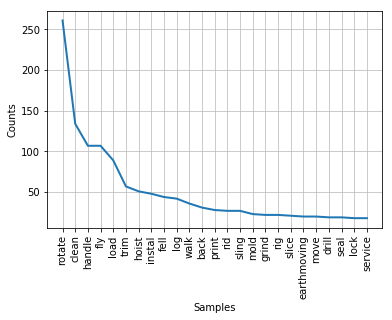

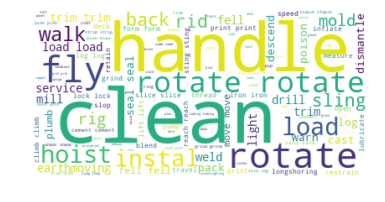

Top 3 activity word and their sentences


rotate

rotating parts hand
rotating parts work rules
rotating shaft
rotating parts
rotating parts rotating shaft
rotating shaft chain sprocket
rotating parts finger
rotating parts
rotating parts aircraft propeller laceration fracture inattention
rotating parts arm



clean
=====

cleaning pump
cleaning air
cleaning air
cleaning point
cleaning air
cleaning fall struck
cleaning conveyor
cleaning rotating parts
cleaning printing machine
cleaning hatch guard lockout



handle

handling ind trk operator
handling auger cleaning
handling motor vehicle
handling fall
handling work rules
handling work rules
handling falling object bleach chemical burn leg
handling roller
handling lockout
handling roller


Falls


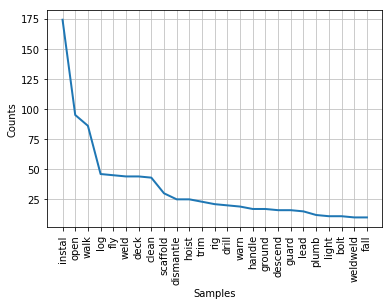

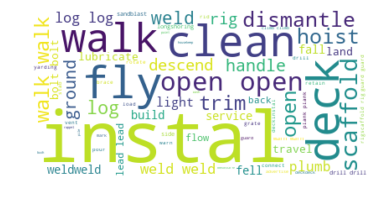

Top 3 activity word and their sentences


instal

installing ladder scaffold structure
installing arm fracture face abrasion
installing work rules
installing wrist
installing stakes
installing wall
installing skylight fall fall protection neck fracture
installing air conditioner
installing air conditioner
installing anchor roof



open
====

opening cover ladder
opening work rules
opening fall protection fall demolition construction asbestos removal work rules
opening cover fall fracture head
opening fall fall protection
opening maintenance ladder catwalk fall head fracture
opening ceiling panel fall protection
opening head
opening ceiling fall
opening shoulder elbow pelvis guardrail cover



walk
====

walking surface
walking on beam
walking surface fall fracture
walking backward construction fall fracture floor
walking surface
walking on beam rafter
walking backward inattention dismantling boat maintenance
walking on beam iron worker contusion
walking surface carpet
walking surface



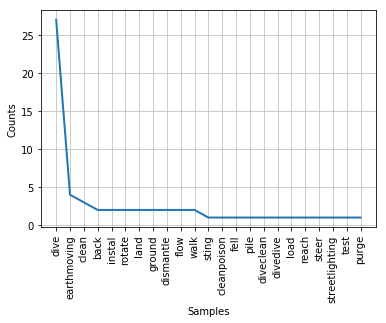

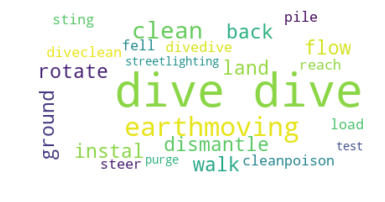

Top 3 activity word and their sentences


dive
====

diving commercial diving
diving air line respirator carbon monoxide
diving embolism inexperience air line mech malfunction air pressure
diving air hose
diving commercial diving
diving drown scuba diving water
diving unconsciousness scuba commercial diving cpr diver water
diving cpr embolism
diving mech malfunction
diving commercial diving cpr scuba boat



earthmoving

earthmoving equip bulldozer
earthmoving equip
earthmoving equip



clean
=====

cleaning poisoning skin ppe
cleaning bee
cleaning drown seizure construction water unconsciousness
cleaning seizure water drown


Other


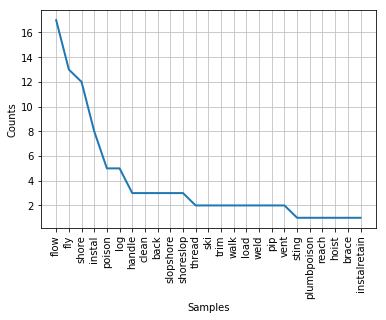

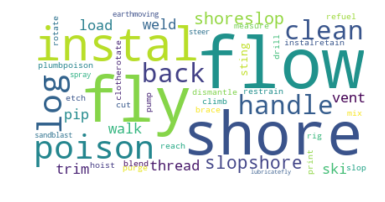

Top 3 activity word and their sentences


flow
====

flowing material
flowing material
flowing material
flowing material
flowing material winch vibrations
flowing material safety
flowing material
flowing material work rules
flowing material
flowing material



fly
===

flying object neck spine valve
flying object
flying object equipment failure
flying object chest
flying object high pressure
flying object lockout
flying object construction pressure release work rules
flying object high pressure
flying object
flying object



shore
=====

shoring excavation
shoring fall ear backhoe
shoring collapse tendon arm leg
shoring collapse
shoring unstable soil pipe
shoring unguarded construction collapse
shoring agriculture
shoring trench box
shoring sloping trench box
shoring sloping work rules


Struck By Moving Objects


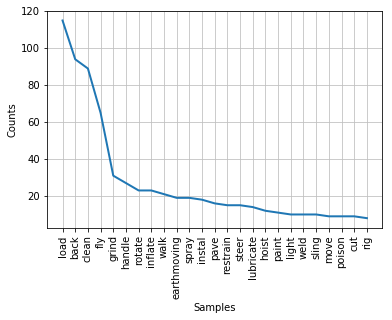

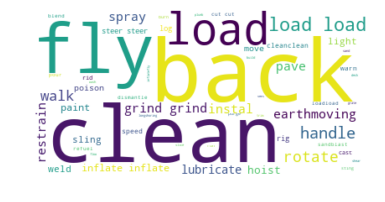

Top 3 activity word and their sentences


load
====

loading machinist abrasive wheel
loading trailer
loading agriculture heat heat exhaustion vomit alcohol
loading dock overturn
loading tractor trailer pallet loading dock run
loading asphalt burn
loading caught
loading dock trailer truck
loading dock
loading trailer backhoe



back
====

backing up brake accelerator pedal
backing up accelerator pedal
backing up back-up alarm
backing up back-up alarm
backing up back-up alarm struck
backing up back-up alarm
backing up back-up alarm struck
backing up back-up alarm
backing up leg fracture motor vehicle
backing up back-up alarm highway road



clean
=====

cleaning conveyor
cleaning lighting fixture acetone
cleaning acetone fire burn
cleaning fluid tractor trailer eye
cleaning anhydrous ammonia chemical vapor chemical inhalation work rules
cleaning tendon laceration puncture
cleaning conveyor
cleaning meat blending mach lockout machine
cleaning guard
cleaning fan fan


Collapse of object


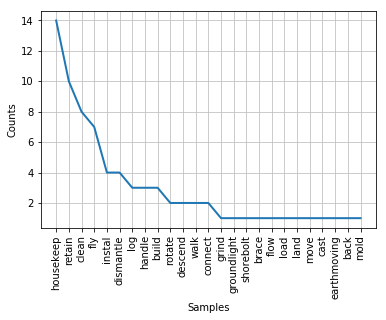

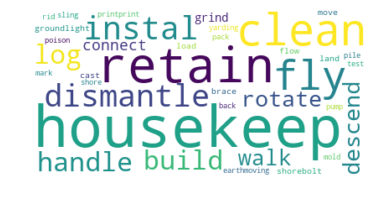

Top 3 activity word and their sentences


housekeep

housekeeping allergic reaction
housekeeping inattention communication
housekeeping fall
housekeeping vapor
housekeeping explosion contusion chest hearing loss
housekeeping fall heart attack cardiac arrest
housekeeping cleaning vacuum
housekeeping janitor cleaning
housekeeping janitor cleaning fall fracture knee slip
housekeeping amputated finger paint cleaning



retain

retaining wall
retaining wall bracing collapse
retaining wall lung
retaining wall collapse
retaining wall
retaining wall
retaining wall lawn mower
retaining wall
retaining wall collapse cleaning demolition
retaining wall underpinning



clean
=====

cleaning extension
cleaning toxic
cleaning lung ppe toxic atmosphere
cleaning unstable soil work rules
cleaning fluid collapse


Fires and Explosion


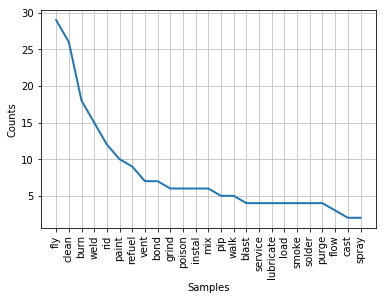

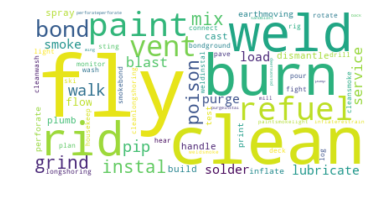

Top 3 activity word and their sentences


fly
===

flying object pipeline blowout
flying object explosion boiler gas leak contusion abrasion food preparation arm
flying object bolt stepladder explosion
flying object cylinder leg rupture
flying object
flying object boiler steam
flying object explosive mixing
flying object chemical chemical reaction contusion
flying object laceration eye face
flying object untrained contusion



clean
=====

cleaning explosion fire burn work rules cleaning fluid ventilation
cleaning hopper coal hatch burn
cleaning benzene static electricity
cleaning burn fire head mixer tank
cleaning coal tar
cleaning combustible liquid burn face arm
cleaning longshoring explosion
cleaning work rules
cleaning flammable vapors
cleaning laceration



burn
====

burning leg burn fire fire extinguisher
burning naphtha fire
burning drum
burning cylinder fire explosion
burning torch oxygen propylene
burn chemical fertilizer mixing irrigation equipment water pump explosion nitr

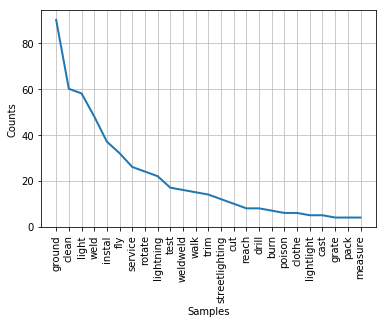

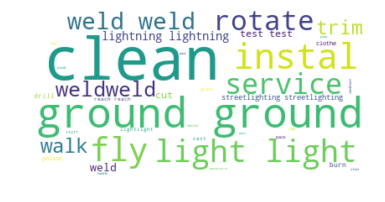

Top 3 activity word and their sentences


ground

grounding untrained e gi vii
grounding attachment plug
grounding cord
grounding conveyor
grounding electric cord attachment plug pump wet operation
grounding attachment plug
grounding elec equipment
grounding welder attachment plug e gi v
grounding electric generator
grounding cord connector attachment plug cord



clean
=====

cleaning work rules
cleaning welding fire
cleaning fluid work rules
cleaning ppe work rules
cleaning brush chipper milling machine guard
cleaning water tank
cleaning poisoning carbon monoxide ventilation gasoline
cleaning food preparation unconsciousness cardiovasc system respiratory
cleaning electric saw casting
cleaning ceiling panel work rules



light
=====

lighting fixture maintenance
lighting fixture
lighting air shaft
lighting circuit airport e gi iv
lightning amuse park/carnival
lighting ladder shock
lighting lockout electric conductor
lighting inexperience
lighting electrocuted maintenance
lighting lock

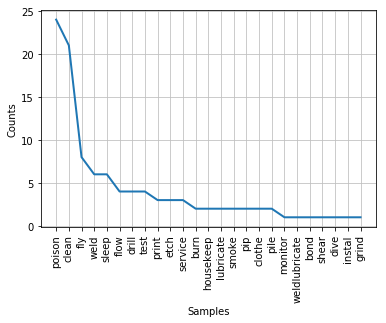

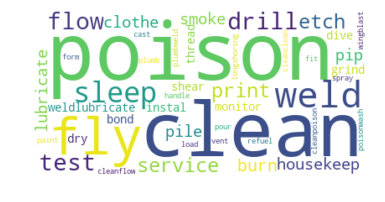

Top 3 activity word and their sentences


poison

poisoning emergency response
poisoning inhalation ventilation
poisoning chemical vapor
poisoning chlorine gas cylinder throat cough vomit eye
poisoning lawn
poisoning ventilation work rules heart
poisoning exhaust fumes
poisoning chemical vapor inhalation gas fumigant
poisoning unconsciousness gas cleaning pool gasoline ventilation
poisoning toxic fumes



clean
=====

cleaning fluid lung air contamination toxic fumes
cleaning bleach chemical reaction
cleaning fluid toxic fumes
cleaning ppe storage tank carbon disulfide
cleaning fluid drain
cleaning oxygen electric drill arm face
cleaning unconsciousness inhalation chemical vapor vapor ppe
cleaning flowing material inhalation
cleaning gas exhaust fumes
cleaning hazardous waste chemical



fly
===

flying object high pressure fire extinguisher rupture guard air pressure
flying object explosion
flying object
flying object chemical vapor
flying object gas
flying object gas leak
flying obje

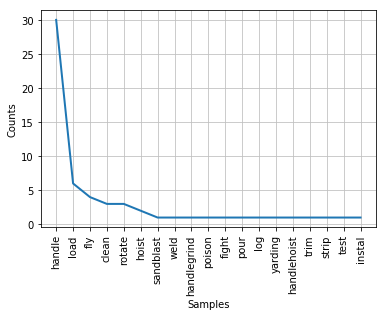

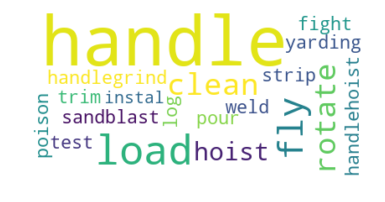

Top 3 activity word and their sentences


handle

handling leg
handling grain
handling baggage conveyor
handling alcohol
handling auger auger mechanism
handling chemical burn
handling chair sprain
handling heart
handling skin dermatitis chemical creosote
handling grinding wheel equipment failure



load
====

loading truck extension handle
loading manual mat handling corn
loading ramp
loading mech mat handling
loading manual mat handling caught
loading heart



fly
===

flying object face
flying object gasket
flying object mech mat handling face puncture barge pier construction
flying object leg fracture extension


Exposure to extreme temperatures


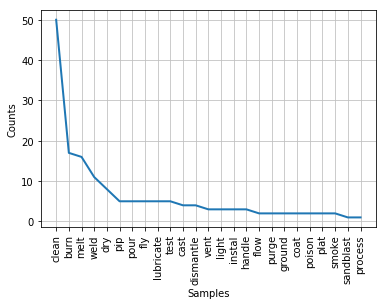

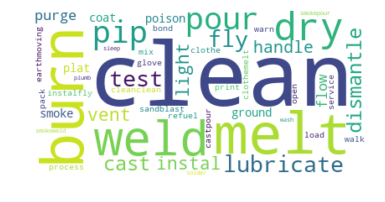

Top 3 activity word and their sentences


clean
=====

cleaning chemical burn ppe jet fuel hand
cleaning maintenance
cleaning ash high temperature
cleaning flammable vapors
cleaning work rules
cleaning carbon disulfide tank
cleaning burn
cleaning fluid
cleaning caustic degreaser chemical work rules
cleaning chemical burn foot ankle



burn
====

burning torch acetylene torch burn explosion hearing loss face neck chest arm
burning flammable vapors
burning drum isopropyl alcohol explosion torch
burning torch scrap metal baler welder
burn chemical burn pressure piping pressure release
burning torch
burning fire burn clothing
burning torch column
burning heptane
burning face



melt
====

melting furnace
melting furnace jack
melting furnace explosion
melting furnace plastic mfg
melting furnace steel molten
melting furnace explosion burn
melting furnace scrap metal steel
melting furnace water chemical work rules
melting furnace furnace chemical reaction work rules
melting furnace


Osha Ext

In [47]:
if ProcessOshaDataSet:
    chunk_count = 0
    verb_count = 0
    for cat in OshaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Osha Extraction Chunk Count is " +  str(chunk_count))
    print("Osha Extraction Verb Count is " +  str(verb_count))       

# Output to excel file with new additional columns for activity and activity chunks

In [48]:
#Write to excel with the additional columns for activity verb 
if ProcessMsiaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in MsiaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    MsiaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    MsiaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('MsiaWithActivity.xlsx',OshaCasesDF)

if ProcessOshaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in OshaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    OshaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    OshaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('OshaWithActivity.xlsx',OshaCasesDF)


# Notes and Observation: 
- For the Msia dataset which is used as training dataset, the summary columns are mostly made up of complete grammatically sound sentences and thus the regular expression parser method is chosen to extract the activity phrases.

- However, for the Osha dataset, not all sentences are complete and grammatically sound like the Msia dataset. Some of the activities descripton in the summary column are made up of just keywords instead of complete sentences thus that could result in these rows data being omitted when perform the regular expression parsing. Thus only about 5000 of the 16000 rows in which activity can be found using the parser developed in Msia dataset.

- Further improvements: Need to tweak the reg parser to cater for the "keywords" style description in the OSHA dataset. Some of the activities captured are actually describing the cause of the incident, thus in order to get a more accurate text mining on activities, prior domain knowledge on what is considered cause and what is activities need to be incorporated.